<a href="https://colab.research.google.com/github/mixa15341/Deep_Learning/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%966/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%966_%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D0%BE%D0%B2_%D0%B4%D0%BB%D1%8F_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BF%D1%80%D0%B8%D0%BA%D0%BB%D0%B0%D0%B4%D0%BD%D1%8B%D1%85_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

### - **N.B.: Во всех заданиях, графический интерфейс для взаимодействия с обученной моделью, реализуется с помощью Gradio!**

### - **Для каждого задания в графическом интерфейсе должно быть встроено минимум 3 примера (sample)**

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета.

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D, Dense, Input, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import cifar100
(x_train, _), (x_test, _) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Преобразование изображений в черно-белые
x_train_gray = np.dot(x_train[...,:3], [0.2989, 0.5870, 0.1140])
x_test_gray = np.dot(x_test[...,:3], [0.2989, 0.5870, 0.1140])
x_train_gray = np.expand_dims(x_train_gray, axis=-1)
x_test_gray = np.expand_dims(x_test_gray, axis=-1)
from keras import layers
input = layers.Input(shape=(32, 32, 1))

In [8]:
# Encoder
from keras.layers import BatchNormalization
from keras.optimizers import Adam
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_7 (Bat  (None, 16, 16, 128)       512 

In [9]:
autoencoder.fit(x_train_gray, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_gray, x_test))

Epoch 1/10
391/391 [==============================] - 31s 73ms/step - loss: 0.0132 - val_loss: 0.0411
Epoch 2/10
391/391 [==============================] - 10s 26ms/step - loss: 0.0105 - val_loss: 0.0130
Epoch 3/10
391/391 [==============================] - 11s 27ms/step - loss: 0.0100 - val_loss: 0.0126
Epoch 4/10
391/391 [==============================] - 10s 26ms/step - loss: 0.0098 - val_loss: 0.0103
Epoch 5/10
391/391 [==============================] - 11s 27ms/step - loss: 0.0096 - val_loss: 0.0096
Epoch 6/10
391/391 [==============================] - 11s 27ms/step - loss: 0.0095 - val_loss: 0.0122
Epoch 7/10
391/391 [==============================] - 10s 26ms/step - loss: 0.0094 - val_loss: 0.0101
Epoch 8/10
391/391 [==============================] - 11s 28ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 9/10
391/391 [==============================] - 12s 30ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 10/10
391/391 [==============================] - 10s 26ms/step - loss: 0.009

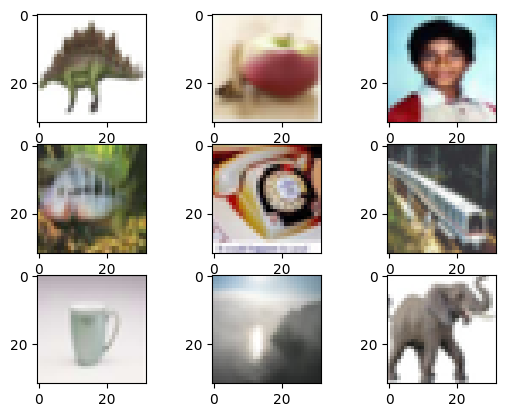

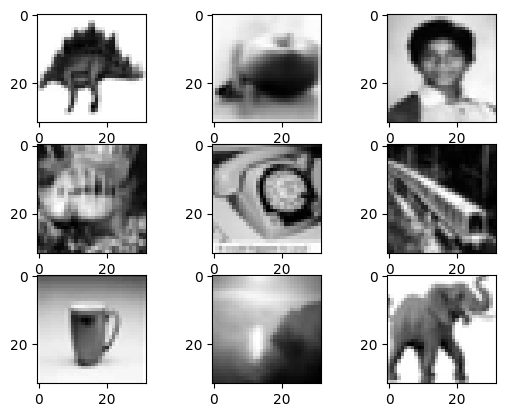

1563/1563 [==============================] - 5s 3ms/step


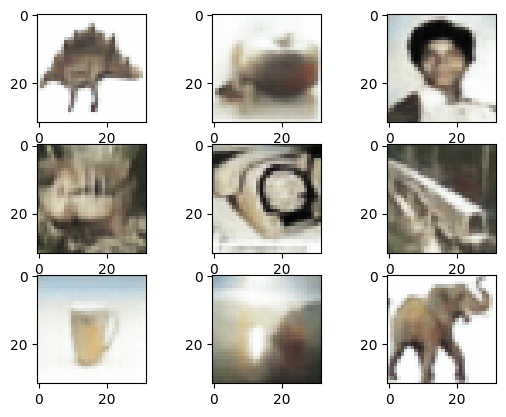

In [11]:
import matplotlib.pyplot as plt
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

plt.show()
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(x_train_gray[i], cmap=plt.get_cmap('gray'))

plt.show()

predictions = autoencoder.predict(x_train_gray)

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(predictions[i], cmap=plt.get_cmap('gray'))

plt.show()

# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras

In [ ]:
# Ваш код

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (апскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку.

3. Обучите модель. Отобразите графики обучения

4. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого можно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [ ]:
# Ваш код